> 시계열 분석을 정리하고자 한다. 다변량 자기회귀모형인 VAR모형과 충격반응(impulse response) 분석, Granger 인과관계, 공적분(cointergration) 등에 대해서 알아보자.

# VAR Model

VAR(Vector Autoregressive) 모델은 여러 시계열 변수가 서로에게 영향을 미치는 상호관계를 분석하기 위한 다변량 시계열 모델이다. VAR 모형은 각 변수가 자신의 과거 값과 다른 변수들의 과거 값을 사용하여 예측되는 구조를 가진다.

$VAR(p)$:

$$Y_t = A_1 Y_{t-1} + A_2 Y_{t-2} + ... + A_p Y_{t-p} + \epsilon_t$$

where

- $Y_t = (y_{1t}, y_{2t}, \dots, y_{nt})'$
- $A_1, A_2, \dots, A_p$는 각각 시차에 대한 계수 행렬
- $p$는 차수(lag)
- $\epsilon_t$는 오차항(white noise) 벡터

또한, 다른 방식으로 쓰면 아래와 같다. Bivariate VAR(1)를 예로 보자.

$y_t = a_1 + b_{11}y_{t-1} + b_{12}x_{t-1} + u_t$

$x_t = a_2 + b_{21}y_{t-1} + b_{22}x_{t-1} + v_t$

Matrix Representation

$\begin{bmatrix}
y_t \\
x_t 
\end{bmatrix} =
\begin{bmatrix}
a_1 \\
a_2 
\end{bmatrix} +
\begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22} 
\end{bmatrix}
\begin{bmatrix}
y_{t-1} \\
x_{t-1}
\end{bmatrix} +
\begin{bmatrix}
u_t \\
v_t
\end{bmatrix}$

- 다변량 분석: VAR 모형은 여러 시계열이 서로 어떻게 영향을 미치는지를 동시에 분석한다.
- 상호 의존성: 각 변수는 다른 변수들의 과거 값에 의해 영향을 받는다.
- 충격 반응 분석(impulse response analysis): 한 변수에 대한 충격이 시간에 따라 다른 변수에 미치는 영향을 분석한다.
- 분산 분해(variance decomposition): 시계열 변동성이 다른 변수의 충격에 의해 얼마나 설명되는지 분석한다.

In [6]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR, SVAR
import matplotlib.pyplot as plt

import statsmodels.datasets

mdatagen = statsmodels.datasets.macrodata.load().data
mdata = mdatagen[['realgdp','infl','realint']]
df = pd.DataFrame(mdata)
df['realgdp'] = df.realgdp.pct_change(4)*100 # 전년동기대비 증감율%
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# VAR 모델 학습
model = VAR(df)
model_fitted = model.fit(3)

# 모델 성능 확인
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 19, Apr, 2024
Time:                     14:35:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    1.62001
Nobs:                     196.000    HQIC:                   1.32139
Log likelihood:          -913.925    FPE:                    3.06032
AIC:                      1.11826    Det(Omega_mle):         2.63593
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              1.041322         0.212434            4.902           0.000
L1.realgdp         1.099091         0.073084           15.039           0.000
L1.infl            0.232696         0.088422            2.632         

## 예측(Forecasting)

- 데이터 준비: 시계열 데이터를 필요에 따라 *정상성* 확보
- 모델 정의: VAR 모델을 데이터에 fit
- 모델 추정: 최적의 lag를 선택하고 모델을 추정
- 예측 수행: 학습된 모델을 이용해 미래의 값 예측

     realgdp_2d   infl_2d  realint_2d
199   -0.688487  2.144457   -2.336378
200    1.206527  1.962201   -2.020657
201    2.915662  1.954942   -1.665079
202    4.227067  1.817433   -1.211757
203    5.012108  1.944107   -0.980159


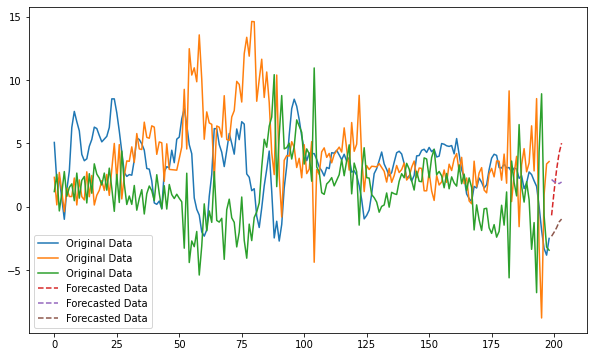

In [7]:
# 예측 (Forecasting)
# 학습된 모델로부터 다음 5일간의 데이터를 예측합니다.
forecast = model_fitted.forecast(model_fitted.endog, steps=5)

# 예측 결과를 DataFrame으로 생성합니다.
df_forecast = pd.DataFrame(forecast, index=range(len(model_fitted.endog),len(model_fitted.endog)+5), columns=df.columns + '_2d')

# 예측 결과 출력
print(df_forecast)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(df, label='Original Data')
plt.plot(df_forecast, label='Forecasted Data', linestyle='--')
plt.legend()
plt.show()

# Structural VAR(SVAR)

Structural VAR (SVAR)는 Vector Autoregression (VAR)의 한 형태로, 경제 이론이나 사전 지식을 모델에 통합하여 변수들 간의 구조적 관계를 규명하는 데 사용된다. 기본적인 VAR 모델이 데이터에 내재된 상호 관계를 경험적으로 모델링하는 데 비해, SVAR은 모델에 구조적인 가정을 추가하여 변수들 간의 인과 관계를 더 명확히 추정한다.

SVAR 모형은 변수의 과거자료뿐만 아니라 여타변수의 현재자료에도​ 영향을 받는 구조이다.

- 구조적 충격(Structural Shocks): SVAR 모델은 경제학적인 이론에 기반하여 각 경제 변수에 대한 구조적인 충격을 설정한다.
- 식별 제약(Identification Constraints): SVAR에서는 변수들 사이의 동시적 관계를 식별하기 위해 특정 제약을 가한다. 이러한 제약은 보통 모델의 고유한 해를 얻기 위해 필요하다.
- 경제 이론 적용: SVAR은 경제 이론을 바탕으로 한 제약 조건을 통해 변수들 간의 구조적 관계를 추론하도록 설계되었다.

$Ay_t = A_1 y_{t-1} + \ldots + A_p y_{t-p} + B\epsilon_t$

SVAR 모델은 주로 A형, B형, AB형 모형으로 분류되는데, 이는 제약을 모델에 적용하는 방식에 따라 달라진다.

- A형 모형: 오차항 분산을 정규화해주어 $B=I$ 인 형태, 변수들 사이의 동시방정식 모델을 식별하기 위해 동시성 제약을 사용
- B형 모형: 피설명변수를 정규화해주어 $A=I$ 인 형태, 주로 충격의 전파 방식을 모델링하는 데 사용

In [8]:
#define structural inputs
A = np.asarray([[1, 'E', 0],['E', 1, 'E'],[0, 'E', 1]])
B = np.asarray([['E', 0, 0], [0, 1, 0], [0, 0, 1]])

model = SVAR(df, svar_type='AB', A=A, B=B)
res = model.fit(maxiter=1000, method='bfgs',maxlags=3)

C:\Users\master\anaconda3\envs\py38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
res.k_exog_user = 0
print(res.summary())

  Summary of Regression Results   
Model:                        SVAR
Method:                        OLS
Date:           Fri, 19, Apr, 2024
Time:                     14:36:07
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    1.62001
Nobs:                     196.000    HQIC:                   1.32139
Log likelihood:          -913.925    FPE:                    3.06032
AIC:                      1.11826    Det(Omega_mle):         2.63593
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              1.041322         0.212434            4.902           0.000
L1.realgdp         1.099091         0.073084           15.039           0.000
L1.infl            0.232696         0.088422            2.632         

사용 예시:

- 변수 $Y_t$는 $n \times 1$ 벡터이고, $Y_t=$[이자율, 인플레이션율, GDP증가율]을 포함한다고 하자.

- A 행렬에는 구조적 충격이 경제에 미치는 즉각적인 효과를 나타내는 식별 제약이 포함된다. 예를 들어, 중앙은행의 정책 이자율은 오로지 통화정책 충격에 의해서만 변할 수 있다고 가정할 수 있다.

- B 행렬은 시간에 따라 변하는 경제 변수들 간의 관계를 나타낸다. 예를 들어, 인플레이션율이 이자율에 미치는 영향을 포착할 수 있다.

- 이러한 SVAR 모델을 추정한 후, 연구자들은 충격 반응 함수(IRF)를 계산하여 통화정책 충격이 인플레이션율이나 GDP에 미치는 영향을 시간에 걸쳐 추적한다. 또한 분산 분해를 통해 각 변수의 변동성이 다른 변수들로부터 얼마나 기인하는지를 파악한다.

# Impulse Response Function(IRF)

충격 반응 함수(Impulse Response Function, IRF)는 하나의 시계열 변수에 대한 예상치 못한 충격이 시스템 내 다른 변수들에 미치는 영향을 시간에 걸쳐 추적한 것이다. 즉, 한 변수가 단위 충격을 받았을 때, 이 충격이 다변량 시계열 시스템 전체에 어떤 영향을 미치는지를 분석하는 방법이다.

- 충격(Shock): 시계열 변수 중 하나가 받는 예상치 못한 변화를 의미한다. 예를 들어, 경제에서는 통화정책 변화, 기술 혁신, 자연재해 등이 충격으로 간주될 수 있다.
- 반응(Response): 충격을 받은 변수를 포함한 시스템 내 다른 변수들이 시간이 지남에 따라 어떻게 반응하는지를 나타낸다. 이 반응은 통상적으로 그래프로 시각화되어 시간에 따른 영향의 크기와 방향을 보여준다.
- 시간 경로(Time Path): 충격 후 변수의 반응이 시간에 따라 어떻게 변화하는지를 나타내는 경로이다. 초기 충격 이후 변수가 얼마나 빠르게 반응하고, 반응이 얼마나 지속되는지를 분석한다.

VAR 모델을 떠올려보자.

$Y_t = A_1 Y_{t-1} + A_2 Y_{t-2} + ... + A_p Y_{t-p} + \epsilon_t$

IRF를 나타내는 데 있어서, 충격 $\epsilon_t$가 시스템에 미치는 영향을 시간에 걸쳐 추적하는 것이 목적이다. 특정 시점 $t$에서 $i$번째 변수에 단위 충격이 가해졌을 때, 이 충격이 시스템에 미치는 영향을 시간 $h$에 걸쳐 추적하는 IRF는 다음과 같이 표현될 수 있다:
$$IRF_{i,h} = \frac{\partial Y_{t+h}}{\partial \epsilon_{i,t}}$$

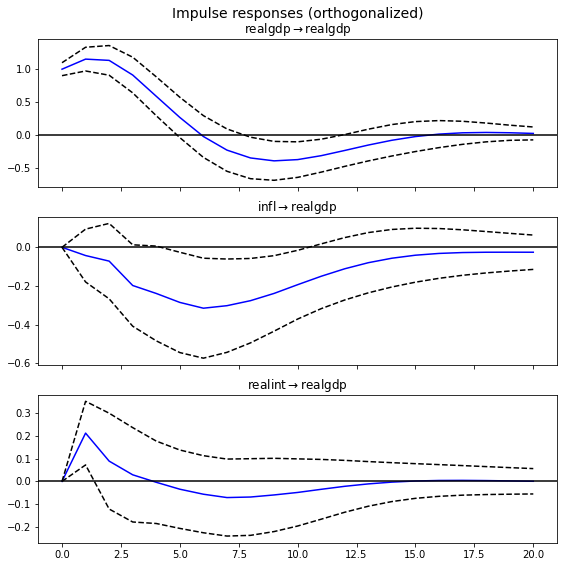

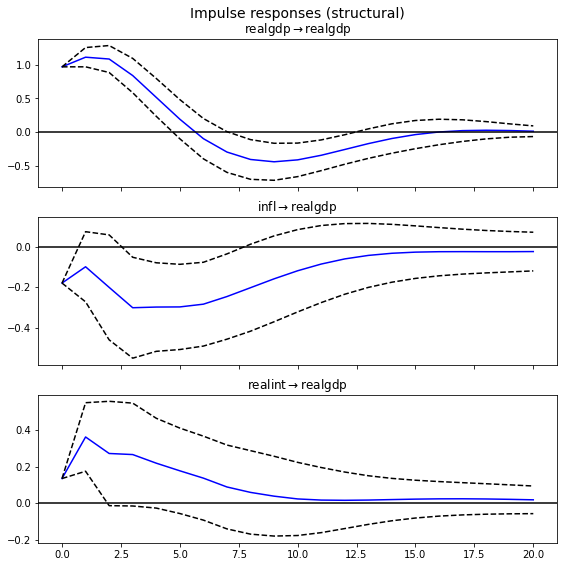

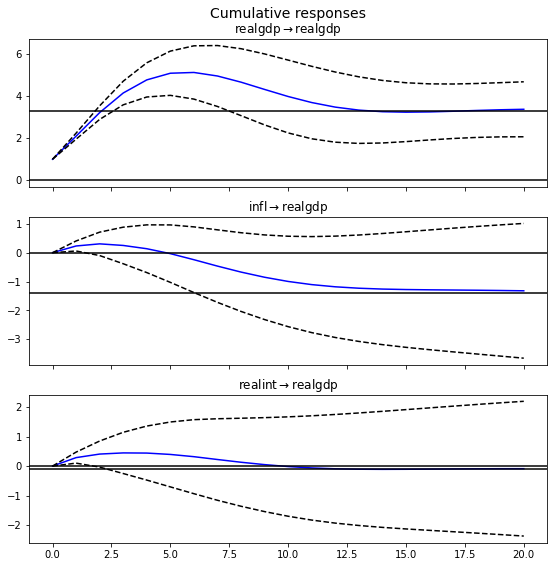

In [10]:
irf = model_fitted.irf(20) #var result
sirf = res.irf(20) #svar result
impulse = ['realint','infl']
response = 'realgdp'
irf.plot(orth=True, response=response, figsize=(8, 8), plot_stderr=True)
sirf.plot(response=response, figsize=(8, 8), plot_stderr=True)
sirf.plot_cum_effects(response=response, figsize=(8, 8), plot_stderr=True)
plt.show()

단, SVAR 모델은 Structural IRF로 측정한다. 이외에도 VAR에서는 Orthogonal IRF(변수 간의 동시 상관관계를 제거한 후 측정), Generalized IRF, Local IRF, Bayesian IRF 등이 있다.

# Granger Causality 테스트

그레인저 인과성(Granger Causality) 테스트는 두 시계열 변수 간의 인과 관계를 통계적으로 검정하는 방법이다. 한 변수의 과거 값이 다른 변수의 현재 값을 예측하는 데 유용한지 여부를 판단하여 인과 관계의 존재를 검증한다.

- 시간 우선성(Temporal Precedence): 인과 관계를 주장하기 위해서는 원인이 되는 사건이 결과에 앞서 발생해야 한다.
- 정보 증가(Information Gain): 원인으로 여겨지는 변수의 과거 값이 결과 변수의 현재 값 예측에 추가적인 정보를 제공해야 한다.

$Y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i Y_{t-i} + \epsilon_t$

$Y_t = \beta_0 + \sum_{i=1}^{p} \beta_i Y_{t-i} + \sum_{j=1}^{q} \gamma_j X_{t-j} + u_t$

그레인저 인과성 검정 절차

- 모델 설정: 두 변수 $X$와 $Y$에 대해, $Y$를 예측하기 위한 두 가지 모델을 설정한다. 첫 번째 모델은 $Y$의 과거 값만을 사용하고, 두 번째 모델은 $Y$의 과거 값과 $X$의 과거 값을 모두 사용한다.

- 모델 추정: 두 모델을 데이터에 적합시킨다.

- 통계적 검정: 두 모델의 적합도를 비교하여, $X$의 과거 값이 $Y$의 예측에 유의미하게 기여하는지 검정한다. 이를 위해 보통 F-통계량을 사용한다.

In [11]:
data = df[['realgdp','infl']]	

from statsmodels.tsa.stattools import grangercausalitytests
gc_res = grangercausalitytests(data, [1,3,5])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3579  , p=0.0217  , df_denom=195, df_num=1
ssr based chi2 test:   chi2=5.4403  , p=0.0197  , df=1
likelihood ratio test: chi2=5.3669  , p=0.0205  , df=1
parameter F test:         F=5.3579  , p=0.0217  , df_denom=195, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5565  , p=0.0566  , df_denom=189, df_num=3
ssr based chi2 test:   chi2=7.9536  , p=0.0470  , df=3
likelihood ratio test: chi2=7.7964  , p=0.0504  , df=3
parameter F test:         F=2.5565  , p=0.0566  , df_denom=189, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4878  , p=0.0330  , df_denom=183, df_num=5
ssr based chi2 test:   chi2=13.1868 , p=0.0217  , df=5
likelihood ratio test: chi2=12.7580 , p=0.0258  , df=5
parameter F test:         F=2.4878  , p=0.0330  , df_denom=183, df_num=5


In [12]:
data = df[['realgdp','realint']]	
gc_res = grangercausalitytests(data, [1,3,5])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2624  , p=0.2626  , df_denom=195, df_num=1
ssr based chi2 test:   chi2=1.2818  , p=0.2576  , df=1
likelihood ratio test: chi2=1.2777  , p=0.2583  , df=1
parameter F test:         F=1.2624  , p=0.2626  , df_denom=195, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1893  , p=0.3151  , df_denom=189, df_num=3
ssr based chi2 test:   chi2=3.7000  , p=0.2957  , df=3
likelihood ratio test: chi2=3.6656  , p=0.2999  , df=3
parameter F test:         F=1.1893  , p=0.3151  , df_denom=189, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9406  , p=0.4560  , df_denom=183, df_num=5
ssr based chi2 test:   chi2=4.9858  , p=0.4176  , df=5
likelihood ratio test: chi2=4.9228  , p=0.4254  , df=5
parameter F test:         F=0.9406  , p=0.4560  , df_denom=183, df_num=5


In [13]:
data = df[['infl','realint']]	
gc_res = grangercausalitytests(data, [1,3,5])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.9258 , p=0.0007  , df_denom=195, df_num=1
ssr based chi2 test:   chi2=12.1093 , p=0.0005  , df=1
likelihood ratio test: chi2=11.7534 , p=0.0006  , df=1
parameter F test:         F=11.9258 , p=0.0007  , df_denom=195, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5034  , p=0.0165  , df_denom=189, df_num=3
ssr based chi2 test:   chi2=10.8995 , p=0.0123  , df=3
likelihood ratio test: chi2=10.6073 , p=0.0141  , df=3
parameter F test:         F=3.5034  , p=0.0165  , df_denom=189, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2191  , p=0.0082  , df_denom=183, df_num=5
ssr based chi2 test:   chi2=17.0629 , p=0.0044  , df=5
likelihood ratio test: chi2=16.3538 , p=0.0059  , df=5
parameter F test:         F=3.2191  , p=0.0082  , df_denom=183, df_num=5


(이자율 --> 인플레이션율)은 꽤나 명확해 보이며, (인플레이션율 --> GDP증가율)도 인과성이 있어보인다.

다만,

- 양방향 인과성: $X$가 $Y$에 대해 그레인저 인과성을 가지고, 동시에 $Y$도 $X$에 대해 그레인저 인과성을 가질 수 있다.
  
- 제3의 원인: $X$와 $Y$간의 그레인저 인과성이 관찰되더라도, 이는 둘 사이에 직접적인 인과 관계가 있다는 것을 의미하지 않을 수 있다. 제3의 변수 $Z$가 $X$와 $Y$ 모두에 영향을 줄 수 있으며, 이를 고려해야 한다.
  
- 데이터의 특성: 그레인저 인과성 검정은 시계열 데이터가 정상성(stationarity)을 만족해야 유효하다. 비정상 시계열의 경우 차분(differencing) 등의 방법으로 데이터를 전처리해야 한다.

# 공적분(Cointegration)

시계열 데이터의 공적분(Cointegration)은 두 개 이상의 비정상 시계열 변수들이 장기적으로 공통된 추세를 공유하고, 이들 간의 일정한 관계가 시간에 따라 안정적으로 유지되는 현상을 의미한다. 이러한 관계는 단기적으로는 변수들이 서로 다른 패턴을 보일 수 있지만, 장기적으로는 같은 균형 상태로 돌아가려는 성질을 가지고 있다.

두 시계열 $X_t$, $Y_t$가 있을 때, 만약 이들이 각각 비정상이지만, 이들의 선형 조합 $Y_t-\beta X_t = u_t$가 정상(stationary) 시계열을 이룬다면, $X_t, Y_t$는 공적분 관계에 있다고 말한다.

공적분의 존재 여부는 여러 통계적 검정을 통해 결정할 수 있으며, 가장 널리 사용되는 방법 중 하나는 **Johansen 공적분 검정**이다.

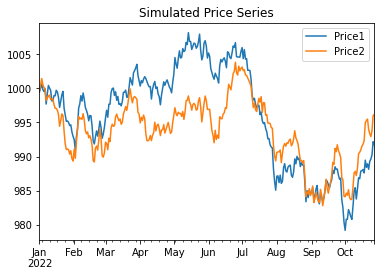

In [14]:
timesteps = 300
common_trend = np.cumsum(np.random.normal(0, 1, timesteps))

# 주가 시뮬레이션
price1 = 1000 + common_trend + np.cumsum(np.random.normal(0, .5, timesteps))  # 첫 번째 주가
price2 = 1000 + common_trend + np.cumsum(np.random.normal(0, .4, timesteps))  # 두 번째 주가

# 잡음 추가
noise1 = np.random.normal(0, .1, timesteps)
noise2 = np.random.normal(0, .1, timesteps)
price1 += noise1
price2 += noise2

# 데이터프레임 생성 및 시각화
df_prices = pd.DataFrame({'Price1': price1, 'Price2': price2}, index=pd.date_range(start='2022', periods=timesteps, freq='D'))
df_prices.plot()
plt.title('Simulated Price Series')
plt.show()

<Axes: >

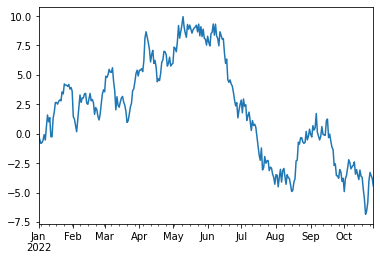

In [15]:
diff = df_prices['Price1'] - df_prices['Price2']
diff.plot()

In [16]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Johansen 공적분 검정 수행
result = coint_johansen(df_prices, det_order=0, k_ar_diff=1)

# 검정 결과 출력
print(f"검정 통계량 (Trace Statistic): {result.lr1}")
print(f"임계값 (Critical Values, 90%, 95%, 99%): {result.cvt}")
print(f"검정 통계량 (Max-Eigen Statistic): {result.lr2}")
print(f"임계값 (Critical Values, 90%, 95%, 99%): {result.cvm}")

검정 통계량 (Trace Statistic): [9.41170433 0.65886094]
임계값 (Critical Values, 90%, 95%, 99%): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
검정 통계량 (Max-Eigen Statistic): [8.75284339 0.65886094]
임계값 (Critical Values, 90%, 95%, 99%): [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


위의 예처럼 두 주가 차의 평균회귀 속성을 이용하여, 주식 간 페어 트레이딩에 사용할 수 있다.

# VECM

Vector Error Correction Model (VECM)은 공적분 관계에 있는 여러 시계열 변수 간의 장기적 균형 관계와 단기적 동조화를 모델링하는 데 사용되는 다변량 시계열 분석 방법이다. 

- 공적분 관계(Cointegration Relationship): 두 개 이상의 비정상적인 시계열 변수가 장기적으로는 어떤 균형 관계를 유지하며 공동으로 움직이는 관계이다. 이러한 변수들은 공적분 벡터에 의해 정의된다.
- 오차수정항(Error Correction Term): 장기 균형으로부터의 편차를 나타내는 항으로, 시계열이 장기적 균형 상태로 복귀하려는 조정 과정을 모델링한다.

$$\Delta Y_t = \alpha (\beta' Y_{t-1} + \gamma) + \sum_{i=1}^{p-1} \Gamma_i \Delta Y_{t-i} + \mu + \epsilon_t$$

여기서,

- $\Delta Y_t$는 시차 $t$에서의 변수의 차분 벡터
- $\alpha$는 오차수정항의 계수(로딩 계수) 벡터, 시계열이 균형으로 복귀하는 속도
- $\beta' Y_{t-1}$은 공적분 벡터로, 장기 균형 관계
- $\gamma$는 공적분 관계의 절편을 조정
- $\Gamma_i$는 단기 동적을 캡처하는 계수 행렬

- 단위근 검정(Unit Root Test): 시계열이 I(1) 과정인지 확인, I(1)은 시계열이 1차 차분을 통해 정상적이 됨을 의미
- 공적분 검정(Cointegration Test): Johansen 검정과 같은 방법을 사용하여 변수들 간의 공적분 관계의 수와 공적분 벡터를 확인
- VECM 추정: 공적분 관계와 단기 동적을 포함하는 VECM을 추정
- 모델 진단: 잔차의 정상성, 자기상관 등을 검토하여 모델의 적합성을 평가

In [17]:
from statsmodels.tsa.vector_ar.vecm import VECM

# VECM 모델 적합
vecm = VECM(df, coint_rank=1)
vecm_fit = vecm.fit()

# 결과 요약 출력
print(vecm_fit.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation realgdp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.realgdp     0.3185      0.067      4.781      0.000       0.188       0.449
L1.infl        0.1091      0.093      1.172      0.241      -0.073       0.291
L1.realint     0.1002      0.096      1.045      0.296      -0.088       0.288
Det. terms outside the coint. relation & lagged endog. parameters for equation infl
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.realgdp     0.0897      0.146      0.613      0.540      -0.197       0.377
L1.infl        0.0932      0.205      0.456      0.649      -0.308       0.494
L1.realint     0.4765      0.211      2.261      0.024       0.063       0.890
Det. terms outside the coint. relation 

# DTW(Dynamic Time Warping)

동적 시간 왜곡(Dynamic Time Warping, DTW)은 두 시계열 데이터 간의 유사도를 측정하는 방법으로, 두 데이터 사이의 시간 축을 동적으로 매핑하여 최소 거리(또는 최대 유사도)를 찾아내는 기법이다. DTW는 시계열 데이터가 서로 다른 속도로 발생하거나 패턴이 시간 축에서 늘어나거나 줄어들 수 있는 경우에 유용하게 사용된다.

- 거리 행렬 생성: 두 시계열 사이의 거리(또는 유사도) 행렬을 생성한다. 이 행렬의 각 원소 $D(i,j)$는 시계열 $X$의 $i$번째 요소와 시계열 $Y$의 $j$번째 요소 사이의 거리(일반적으로 유클리드 거리)를 나타낸다.

- 누적 거리 계산: 각 셀을 현재 셀의 거리와 이전 셀들의 누적 거리 합의 최소값으로 업데이트하며 누적 거리 행렬을 계산한다. 이는 시작점에서 현재 셀에 이르기까지의 최소 거리 경로를 찾기 위한 과정이다.

- 최적 경로 찾기: 누적 거리 행렬의 마지막 셀에서 시작하여, 시작 셀로 되돌아가는 최적 경로(즉, 최소 누적 거리를 가지는 경로)를 역추적한다. 이 경로는 두 시계열 사이의 최소 거리 매핑을 나타낸다.

$$D(i,j)=d(x_i,y_j)+\min\{D(i-1,j-1),D(i-1,j),D(i,j-1)\}$$

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



24.51251354832234

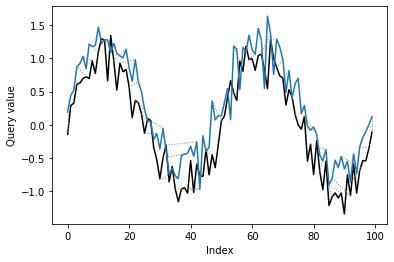

In [18]:
import dtw

time = np.arange(100)
ts_a = np.sin(time / 8) + np.random.normal(scale=0.2, size=100)
ts_b = np.sin(time / 8) + np.random.normal(scale=0.2, size=100) + 0.3

dtw.dtw(ts_a, ts_b, keep_internals=True).plot(type="twoway")
dtw.dtw(ts_a, ts_b, keep_internals=True).distance